## This file runs the Dolo RBC model with iid shocks.

In [4]:
# set-up the Dolo directory
path=Pkg.dir("Dolo")
import Dolo
using AxisArrays

. To use SymEngine call Pkg.add("SymEngine")


In [7]:
# import the YAML file 
filename=("https://raw.githubusercontent.com/EconForge/dolo_models/master/RBCS/rbc_iid.yaml")

"https://raw.githubusercontent.com/EconForge/dolo_models/master/RBCS/rbc_iid.yaml"

In [8]:
# convert the YAML file into model using import
model=Dolo.yaml_import(filename)

Model 


MethodError: MethodError: no method matching sanitize(::Expr, ::Dolo.Model{Symbol("##345")})[0m
Closest candidates are:
  sanitize(::Expr, [1m[31m::Array{Symbol,1}[0m) at C:\Users\Angela\AppData\Local\JuliaPro-0.5.1.1\pkgs-0.5.1.1\v0.5\Dolo\src\printing.jl:14
  sanitize(::Any, [1m[31m::Array{Symbol,1}[0m) at C:\Users\Angela\AppData\Local\JuliaPro-0.5.1.1\pkgs-0.5.1.1\v0.5\Dolo\src\printing.jl:3
  sanitize(::Any, [1m[31m::Dolo.SModel{ID}[0m) at C:\Users\Angela\AppData\Local\JuliaPro-0.5.1.1\pkgs-0.5.1.1\v0.5\Dolo\src\printing.jl:32[0m

In [14]:
# look up some characteristics of the model
print(sqrt(model.exogenous.Sigma)) # standard deviation of the shock 

[0.016]

We can also look up some other features of the model.

In [26]:
display( model.name )   
display(model.symbols)
print(model)

"Real Business Cycle"

DataStructures.OrderedDict{Symbol,Array{Symbol,1}} with 7 entries:
  :rewards      => Symbol[:u]
  :states       => Symbol[:z,:k]
  :parameters   => Symbol[:beta,:sigma,:eta,:chi,:delta,:alpha,:rho,:zbar,:sig_…
  :expectations => Symbol[:m]
  :values       => Symbol[:V]
  :exogenous    => Symbol[:e_z]
  :controls     => Symbol[:n,:i]

Model 


So here the shock we have is iid: $\epsilon$ is $N(0,0.016)$

Now we want to simulate the RBC Model. We need to set $N$, the number of simulations, and $T$, the number of periods to simulate. We're going to use the $simulate$ package in $Dolo$ to do this.

In [17]:
N=50 # number of simulations
T=1000 # time period

# simulation (essentially just drawing N*T realizations of the random variable)
sim_iid=Dolo.simulate(model.exogenous,N,T)

3-dimensional AxisArray{Float64,3,...} with axes:
    :V, 1:1
    :N, 1:50
    :T, 1:1000
And data, a 1×50×1000 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0138308  -0.00788172  0.0160055  …  -0.0333509  0.0151396  0.0279495

[:, :, 3] =
 0.0245253  -0.00223584  -0.0271897  0.016026  …  0.00372498  -0.00601802

...

[:, :, 998] =
 0.00789333  -0.0106166  -0.00160502  0.00599847  …  -0.0245441  -0.00271672

[:, :, 999] =
 -0.00882526  0.0015886  0.0340817  …  -0.005626  0.00593855  -0.00676711

[:, :, 1000] =
 0.0186911  0.0233837  -0.0233316  …  -0.0466188  0.0273267  -0.0043636

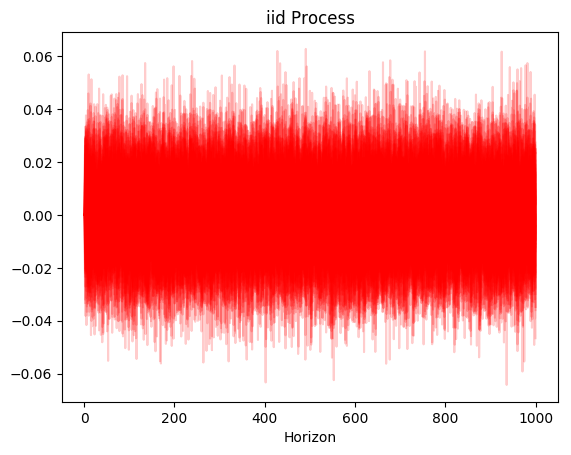

PyObject <matplotlib.text.Text object at 0x0000000027D91A58>

In [21]:
# Plot the simulated process

import PyPlot
plt = PyPlot;

hor= linspace(1, T, T)
for i in 1:size(sim_iid,2)
    plt.plot(hor, vec(sim_iid[:,i,:]), color="red", alpha = .2)
end

plt.xlabel("Horizon");
plt.title("iid Process")

We now want to solve the model - here we use time iteration which is essentially iterating on the residuals of the arbitrage equations.

In [27]:
@time dr_gdp = Dolo.time_iteration(model, verbose=false, maxit=10000, details=false);

 31.393489 seconds (122.83 M allocations: 8.926 GB, 4.86% gc time)


In [30]:
#Simulating a decision rule for GDP-discretization case
df_gdp = Dolo.tabulate(model, dr_gdp, :k) 
#what the simulation does: for 100 values of k, it looks at what the capital, labour, and investment is

2-dimensional AxisArray{Float64,2,...} with axes:
    :V, Symbol[:e_z,:z,:k,:n,:i]
    :k, [4.67749,4.77198,4.86648,4.96097,5.05547,5.14996,5.24446,5.33895,5.43345,5.52794  …  13.182,13.2765,13.371,13.4655,13.56,13.6545,13.749,13.8435,13.938,14.0325]
And data, a 5×100 Array{Float64,2}:
 0.0       0.0       0.0       0.0       …   0.0        0.0        0.0     
 0.0       0.0       0.0       0.0           0.0        0.0        0.0     
 4.67749   4.77198   4.86648   4.96097      13.8435    13.938     14.0325  
 0.435688  0.432323  0.429002  0.425761      0.274005   0.273139   0.272278
 0.278223  0.277245  0.276251  0.275233      0.179054   0.178114   0.177173

Now let's plot what the labour decision looks like.

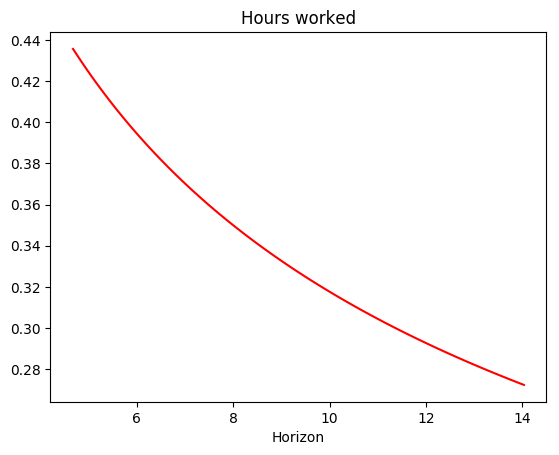

In [31]:
hor= linspace(1, T, T)

fig = plt.figure("Labour")

plt.plot(df_gdp[:k], df_gdp[Axis{:V}(:n)], color="red", label="Hours worked")
plt.xlabel("Horizon");
plt.title("Hours worked");

We can also time the solution algorithm for the time_iteration method

In [34]:
@time dr = Dolo.time_iteration(model, maxit=100, verbose=false, details=false)
@time res = Dolo.time_iteration(model, dr; maxit=100, details=true)

 14.879931 seconds (77.75 M allocations: 5.806 GB, 5.86% gc time)
It    SA          gain        nit  
-----------------------------------
0     1.81e-05    NaN         0    
1     1.14e-05    6.28e-01    1    
2     1.09e-05    9.61e-01    1    
3     1.05e-05    9.62e-01    1    
4     1.01e-05    9.63e-01    1    
5     9.76e-06    9.63e-01    1    
6     9.41e-06    9.64e-01    1    
7     9.08e-06    9.65e-01    1    
8     8.76e-06    9.65e-01    1    
9     8.47e-06    9.66e-01    1    
10    8.19e-06    9.67e-01    1    
11    7.92e-06    9.67e-01    1    
12    7.65e-06    9.67e-01    1    
13    7.39e-06    9.66e-01    1    
14    7.14e-06    9.65e-01    1    
15    6.89e-06    9.65e-01    1    
16    6.64e-06    9.64e-01    1    
17    6.40e-06    9.64e-01    1    
18    6.17e-06    9.63e-01    1    
19    5.94e-06    9.63e-01    1    
20    5.72e-06    9.62e-01    1    
21    5.50e-06    9.62e-01    1    
22    5.29e-06    9.62e-01    1    
23    5.08e-06    9.61e-01    1   

Results of Time Iteration Algorithm
 * Complementarities: true
 * Decision Rule type: Dolo.TimeIterationResult
 * Number of iterations: 70
 * Convergence: true
   * |x - x'| < 1.0e-08: true


In [39]:
Dolo.simulate(model, dr)
s0 = model.calibration[:states]+0.1
print(s0)

[0.1,9.45498]

In [46]:

Dolo.simulate(model, dr; N=10)

res = Dolo.response(model.exogenous, [0.01])

irf = Dolo.response(model, dr, :e_z)


2-dimensional AxisArray{Float64,2,...} with axes:
    :V, Symbol[:e_z,:z,:k,:n,:i]
    :T, 1:40
And data, a 5×40 Array{Float64,2}:
 0.0       0.016     0.0       0.0       …  0.0        0.0         0.0       
 0.0       0.016     0.0128    0.01024      5.1923e-6  4.15384e-6  3.32307e-6
 9.35498   9.34746   9.35941   9.36711      9.23125    9.22819     9.22524   
 0.327152  0.329395  0.328802  0.328352     0.329063   0.32911     0.329156  
 0.226356  0.24564   0.241684  0.238536     0.227723   0.227755    0.227787  

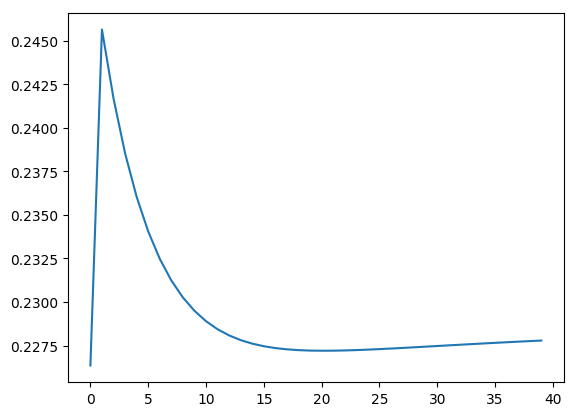

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000026A135F8>

In [49]:
# Plot the investment response.
plt.plot(irf[:i])